# Multi-Spike Tempotron
An implementation of the binary tempotron in Julia. 
For further details see [Gütig, R. (2016). Spiking neurons can discover predictive features by aggregate-label learning. Science, 351(6277), aab4113.](https://science.sciencemag.org/content/351/6277/aab4113).

## Imports

In [1]:
push!(LOAD_PATH, abspath("../"))
using Tempotrons
using Tempotrons.InputGen
using Tempotrons.Plots
using Tempotrons.Optimizers
using Plots;

## Set parameters

In [2]:
N = 10
T = 500
dt = 0.1
t = collect(0:dt:T)
ν = 3
λ = 0.1
opt = RMSprop(λ)
n_samples = 10
n_classes = 5
n_steps = 1000
tmp = Tempotron(N = N);

## Generate input samples

In [3]:
base_samples = [[PoissonSpikeTrain(ν = ν, T = T)
                 for i = 1:N]
                for j = 1:n_classes]
samples = [(x = [SpikeJitter(s, T = T, σ = 5)
                 for s ∈ base_samples[n_classes*(j - 1)÷n_samples+1]],
            y = n_classes*(j - 1)÷n_samples)
           for j = 1:n_samples];

## Training

In [4]:
# Get the tempotron's output before training
out_b = [tmp(s.x, t = t)[2] for s ∈ samples]

# Train the tempotron
@time for i = 1:n_steps
    s = rand(samples)
    Train!(tmp, s.x, s.y, optimizer = opt, T_max = T)
end

# Get the tempotron's output after training
out_a = [tmp(s.x, t = t)[2] for s ∈ samples];

 10.381728 seconds (29.78 M allocations: 1.109 GiB, 5.21% gc time)


## Plots

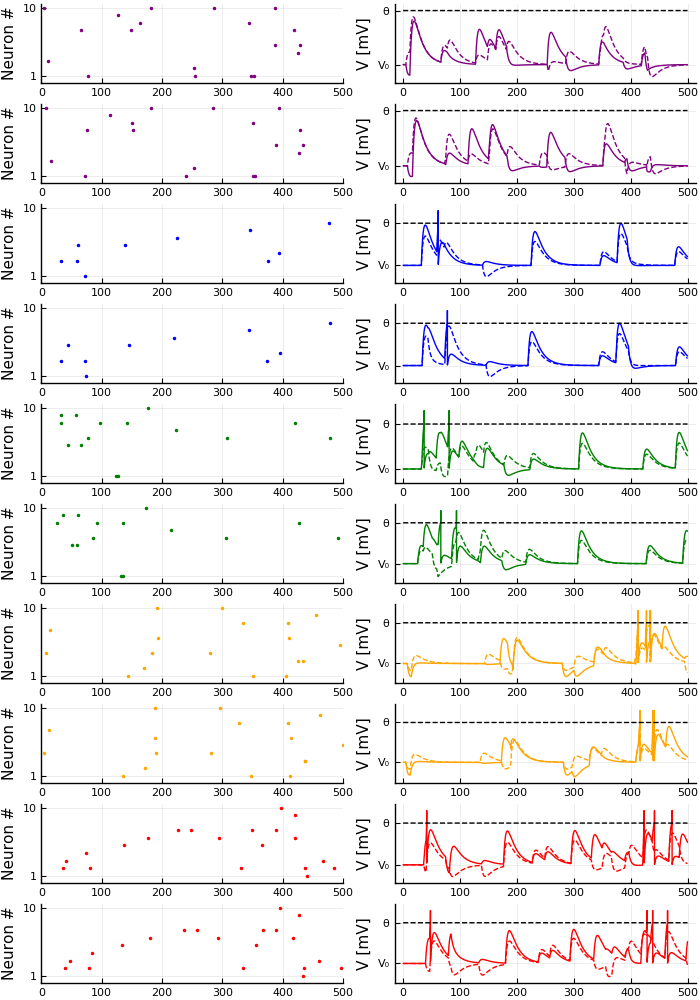

In [5]:
# Prepare to plot
pyplot(size = (700, 1000))
C(g::ColorGradient) = RGB[g[z]
    for z = range(0, stop = 1, length = n_classes)]
clibrary(:misc)
g = :rainbow
cols = cgrad(g) |> C

# Plots
inp_plots = [PlotInputs(s.x, T_max = T, color = cols[s.y + 1])
  for s ∈ samples]
train_plots = [PlotPotential(tmp, out_b = out_b[i], out_a = out_a[i],
                             t = t, color = cols[samples[i].y + 1])
                for i = 1:length(samples)]
ps = vcat(reshape(inp_plots, 1, :), reshape(train_plots, 1, :))
plot(ps[:]..., layout = (length(inp_plots), 2))